# Numpyro version

This is about 100x faster! and the code is nicer! joy oh joy!

# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

This notebook will be dedicated to estimating parameters within some __simulated data__.

In [1]:
%config IPCompleter.use_jedi = False
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

In [2]:
## starting with just one P b/c I am struggling w/ python rustiness and filepaths
from dfply import *
import glob
import pandas as pd

## just to get the skeleton of the final data format
df_raw = pd.read_csv("osfstorage-archive/Experiment 2/PrEstExp_001_111218_115935.csv")
df = (df_raw >> 
      group_by(X.querytype) >> 
      summarize(estimate = X.estimate.mean()) >>
      mutate(estimate = X.estimate/100.)
     )

## Simulate data

## create and fit model

k is relatively independent of both Beta and k though, so that's good.

In [3]:
import torch as t

trial_funcs = dict({
    "AandB": lambda theta: t.matmul(theta, t.tensor([1.,0.,0.,0.])) ,
    "AandnotB": lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,0.])),
    "notAandB": lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,0.])),
    "notAandnotB": lambda theta: t.matmul(theta, t.tensor([0.,0.,0.,1.])),
    "A":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,0.])),
    "B":lambda theta: t.matmul(theta, t.tensor([1.,0.,1.,0.])),
    "notA":lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,1.])),
    "notB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    "AorB":lambda theta: t.matmul(theta, t.tensor([1.,1.,1.,0.])),
    "AornotB":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,1.])),
    "notAorB":lambda theta: t.matmul(theta, t.tensor([0.,1.,1.,1.])),
    "notAornotB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    
    "AgB": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "notAgB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "AgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "notAgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "BgA": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "notBgA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "BgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) ),
    "notBgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) )
})

def sim_sampling(p, beta, N, k):
    p_bs = p * N / (N + 2.*beta) + beta/(N + 2.*beta)
    return t.distributions.Beta(p_bs*k, (1-p_bs)*k).sample()


def dm_probs(trial_data, theta, n_obs):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    p = t.tensor([])
    for i in range(0, n_obs):
        temp = trial_funcs[trial_data[i]](theta)
        p = t.cat( (p, t.tensor([temp])), 0)

    return p


## ------
## simulate data into pandas DataFrame
## -------
n_participants = 20
n_blocks = 3

# trial_types = trial_types[1:4]
trial_types = list(df.querytype)
n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
all_trials = trials*n_participants
all_blocks = blocks*n_participants
all_responses = t.ones(0)

all_thetas = []

for i in range(0, n_participants):
    theta = t.distributions.Dirichlet(t.ones(4)).sample()

    probs = dm_probs(trials, theta, len(trials))
    responses = sim_sampling(probs, beta=1, N=10, k=100)
    
    all_thetas.append(theta)
    all_responses = t.cat((all_responses, responses))

all_responses = all_responses.cpu().detach().numpy()


sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)

sim_data

,ID,querytype,block,response
0,0,A,0,0.373147
1,0,AandB,0,0.204150
2,0,AandnotB,0,0.231558
3,0,AgB,0,0.424985
4,0,AgnotB,0,0.293735
...,...,...,...,...
1195,19,notAorB,2,0.592822
1196,19,notAornotB,2,0.483579
1197,19,notB,2,0.585177
1198,19,notBgA,2,0.373336


In [4]:
#### new API

### first make a design matrix

num_vecs = dict({
    "AandB": jnp.array([1.,0.,0.,0.]),
    "AandnotB": jnp.array([0.,1.,0.,0.]),
    "notAandB": jnp.array([0.,0.,1.,0.]),
    "notAandnotB": jnp.array([0.,0.,0.,1.]),
    "A":jnp.array([1.,1.,0.,0.]),
    "B":jnp.array([1.,0.,1.,0.]),
    "notA":jnp.array([0.,0.,1.,1.]),
    "notB":jnp.array([0.,1.,0.,1.]),
    "AorB":jnp.array([1.,1.,1.,0.]),
    "AornotB":jnp.array([1.,1.,0.,1.]),
    "notAorB":jnp.array([0.,1.,1.,1.]),
    "notAornotB":jnp.array([0.,1.,0.,1.]),
   
    "AgB": jnp.array([1.,0.,0.,0.]),
    "notAgB": jnp.array([0.,0.,1.,0.]),
    "AgnotB": jnp.array([0.,1.,0.,0.]),
    "notAgnotB": jnp.array([0.,0.,0.,1.]),
    "BgA": jnp.array([1.,0.,0.,0.]),
    "notBgA": jnp.array([0.,1.,0.,0.]),
    "BgnotA": jnp.array([0.,0.,1.,0.]),
    "notBgnotA": jnp.array([0.,0.,0.,1.])
})

denom_vecs = dict({
    "AandB":  jnp.array([1.,1.,1.,1.]),
    "AandnotB":  jnp.array([1.,1.,1.,1.]),
    "notAandB":  jnp.array([1.,1.,1.,1.]),
    "notAandnotB":  jnp.array([1.,1.,1.,1.]),
    "A": jnp.array([1.,1.,1.,1.]),
    "B": jnp.array([1.,1.,1.,1.]),
    "notA": jnp.array([1.,1.,1.,1.]),
    "notB": jnp.array([1.,1.,1.,1.]),
    "AorB": jnp.array([1.,1.,1.,1.]),
    "AornotB": jnp.array([1.,1.,1.,1.]),
    "notAorB": jnp.array([1.,1.,1.,1.]),
    "notAornotB": jnp.array([1.,1.,1.,1.]),
    
    "AgB": jnp.array([1.,0.,1.,0.]),
    "notAgB": jnp.array([1.,0.,1.,0.]),
    "AgnotB": jnp.array([0.,1.,0.,1.]),
    "notAgnotB": jnp.array([0.,1.,0.,1.]),
    "BgA": jnp.array([1.,1.,0.,0.]),
    "notBgA": jnp.array([1.,1.,0.,0.]),
    "BgnotA": jnp.array([0.,0.,1.,1.]),
    "notBgnotA": jnp.array([0.,0.,1.,1.])
})

trial_list = list(sim_data.querytype)
X_num = jnp.stack([num_vecs[trial] for trial in trial_list])
X_denom = jnp.stack([denom_vecs[trial] for trial in trial_list])


test_data2 = {
    "trial": trial_list,
    "X_num": X_num,
    "X_denom": X_denom,
    "subj": list(sim_data.ID),
    "block": list(sim_data.block),
    "obs": jnp.array(sim_data.response.to_numpy())
}

# test_info2 = {"n_Ps":n_participants, "n_blocks":n_blocks, "n_trials":20}

def bayesian_sampler(data):

    n_Ps = len(np.unique(data["subj"]))
    trial = data["trial"]
    subj = data["subj"]

    # population level parameters/priors
    beta = numpyro.sample("beta", dist.HalfCauchy(.25))
    N = numpyro.sample("N", dist.HalfCauchy(5))
    k = numpyro.sample("k", dist.HalfCauchy(10)) ## noise, all causes

    # need a theta per person/querytype 
    with numpyro.plate("subj", n_Ps):
        theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
        
    numerator = jnp.sum(theta[subj,:]*data["X_num"], axis=-1) # the indexing is the key!!!!!
    denom = jnp.sum(theta[subj,:]*data["X_denom"], axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)

    with numpyro.plate("data", data["obs"].shape[0]):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data["obs"])
    
    return yhat

In [5]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(bayesian_sampler)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=2)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, test_data2)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [6]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          N      5.66      7.96      3.52      0.11     11.22    789.55      1.00
       beta      0.54      0.75      0.34      0.02      1.07    800.52      1.00
          k    103.11      4.25    103.05     96.38    110.44   2358.25      1.00
 theta[0,0]      0.17      0.01      0.18      0.16      0.19   3123.41      1.00
 theta[0,1]      0.20      0.01      0.20      0.18      0.21   3124.35      1.00
 theta[0,2]      0.21      0.01      0.21      0.19      0.22   3578.10      1.00
 theta[0,3]      0.42      0.01      0.42      0.40      0.44   3229.31      1.00
 theta[1,0]      0.03      0.00      0.03      0.02      0.04   1812.74      1.00
 theta[1,1]      0.47      0.01      0.47      0.45      0.49   2358.08      1.00
 theta[1,2]      0.13      0.01      0.13      0.12      0.14   1963.34      1.00
 theta[1,3]      0.37      0.01      0.37      0.35      0.39   2705.70      1.00
 theta[2,0]    

it works! and much faster

In [13]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc)

numpyro_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
az.waic(numpyro_data)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 1200 log-likelihood matrix

          Estimate       SE
elpd_waic  2067.86    24.84
p_waic       59.75        -

There has been a warning during the calculation. Please check the results.

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='beta', ylabel='N'>, <AxesSubplot:>]],
      dtype=object)

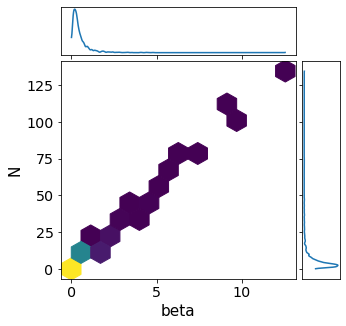

In [15]:
az.plot_pair(
    numpyro_data,
    var_names=["beta","N"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(5, 5),
)